In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")

import numpy as np
import pandas as pd
from lightcurve_fitting import models, lightcurve
from lightcurve_fitting import filters as flc
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp
import utils.utils as ut
import utils.analysis as an
# import lc
import os
torch.set_default_dtype(torch.float64)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"][::-1]#[-2:]  # from red to UV
mjd_array = np.linspace(3, 13, 600)


filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

max_days = 7
time_spans = np.arange(1, max_days + 1)  # [1, 2, ..., 10]

model_parameters = [1.2, 2., 2., 4.0, 2.5]

# --- setup light curve builder ---
builder = ut.LCBuilder(
    model_name="sc4",
    model_parameters=model_parameters,
    model_units=[1,1,1,1,1],
    seed=42)

lc = builder.build_sim_lc(
    mjd_array=mjd_array,
    filters_list=all_filters,  # full set
    redshift=0.00526,
    dlum_factor=1e-1/2,
    dm=31.1,
    dL=19.,
    dLerr=2.9
)

In [6]:
def get_filter_mask(lc, filters):
    filter_objects = [flc.filtdict[f] for f in filters]
    fmask = np.in1d(lc["filter"].value, filter_objects)
    return fmask

lc_subset = lc.where(MJD_max=lc["MJD"].min() + max_days)
lc_subset = lc_subset[get_filter_mask(lc_subset, filter_combinations[3])]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torchenizer = tp.Torchenizer(lc_subset, ycol="loglum", device=device)

X_DATA, filters_mask, ufilters = torchenizer.get_xdata(max_phase=max_days, t0_offset=3)

Using device: cuda


In [ ]:
nn_model_name = "bnn_pilca_early_stop_ugri_5d.pth"
model_save_dir = os.path.join(ut.storage_parent_path, "models", nn_model_name)

nn_model = tp.MultiFilterBNN(x_data=X_DATA,
                            filters_mask=filters_mask,
                            param_dim=4,
                            hidden_dim=16,
                            n_filter_layers=1,
                            n_combined_layers=2).to(device)

criterion = tp.ModifiedSC4Loss(ufilters=ufilters,
                               z=lc.meta["redshift"],
                               mode="mean_param",
                               min_t0=torch.min(X_DATA[:,0])-1e-5,
                               fixed_frhom=builder.model_parameters[2])
lr=1e-2
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=150, gamma=0.5)

trainer = tp.Trainer(model=nn_model,
                    criterion=criterion,
                    epochs=2000,
                    n_samples_loss=50,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    verbose_step=1,
                    save_dir=model_save_dir,
                    es_kwargs={"use_es":True,
                               "patience":200,
                               "save_best_loss":True},
                    change_loss=True)

history = trainer.train()

--- Step 0 ---
Shock velocity (v_s):     4.9408
Envelope mass (M_env):    4.1396
Density factor (f_rho_M): 4.1396
Radius (R):               5.1237
Explosion time (t_exp):   5.3191
Loss:                     1.266001
----------------------------------------
--- Step 1 ---
Shock velocity (v_s):     3.6247
Envelope mass (M_env):    2.0919
Density factor (f_rho_M): 2.0919
Radius (R):               4.8874
Explosion time (t_exp):   4.6109
Loss:                     0.706057
----------------------------------------
--- Step 2 ---
Shock velocity (v_s):     1.5894
Envelope mass (M_env):    0.6034
Density factor (f_rho_M): 0.6034
Radius (R):               4.3899
Explosion time (t_exp):   3.9380
Loss:                     0.033199
----------------------------------------
--- Step 3 ---
Shock velocity (v_s):     0.1364
Envelope mass (M_env):    0.0425
Density factor (f_rho_M): 0.0425
Radius (R):               2.5831
Explosion time (t_exp):   2.1985
Loss:                     3.546727
-----------------

In [ ]:
torch.mean(X_DATA[:,2])

tensor(0.0204, device='cuda:0')

In [ ]:
samples = []
for i in range(1000):
    samples.append(nn_model())
samples = torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]

print(samples.shape)


(1000, 5)


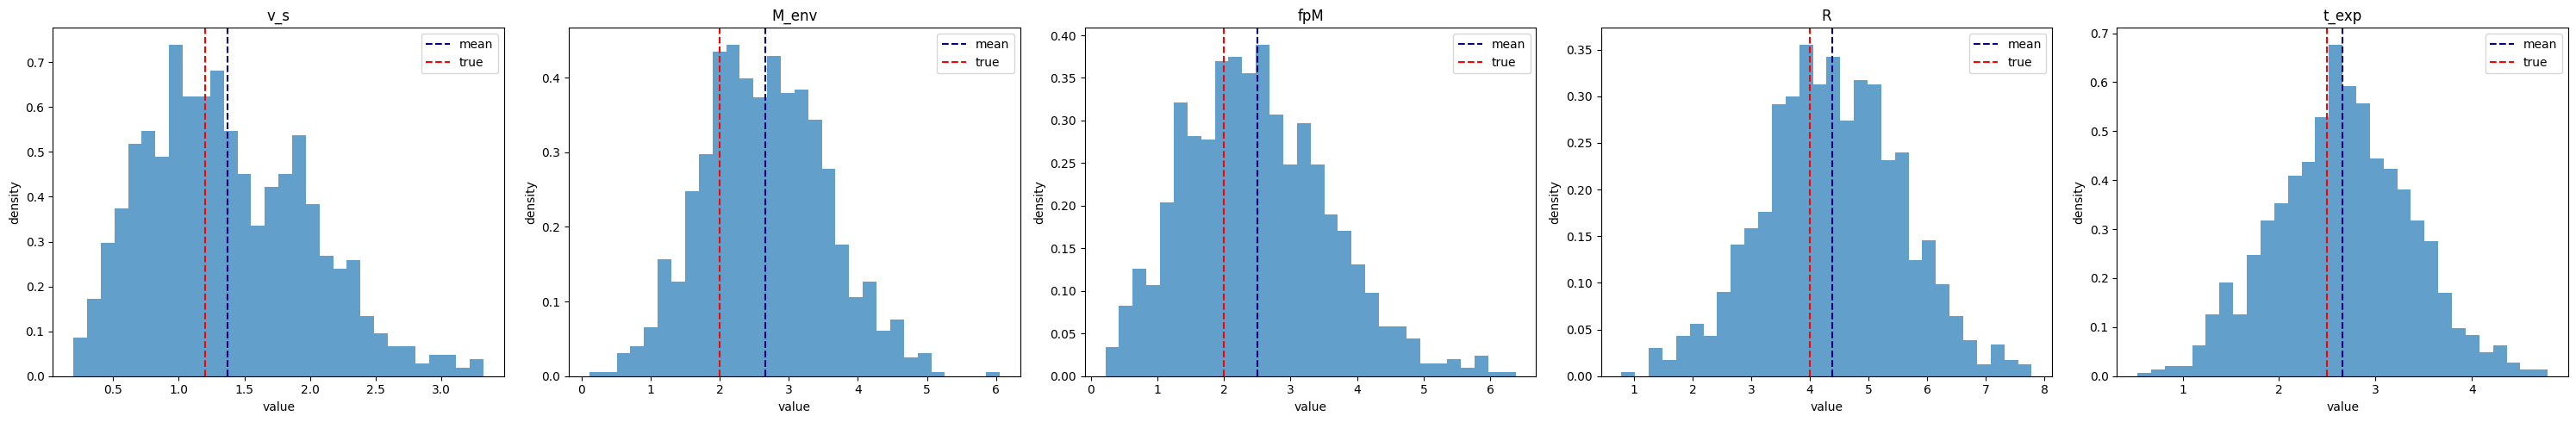

In [ ]:
param_names = ["v_s", "M_env", "fpM",  "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = builder.model_parameters
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")


    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
1+1

In [ ]:
model = models.ModifiedShockCooling4(lc)
an.lc_modeling_plot(lc=lc, samples=samples, model=model, ycol="loglum")

NameError: name 'models' is not defined

(0.0, 0.1)

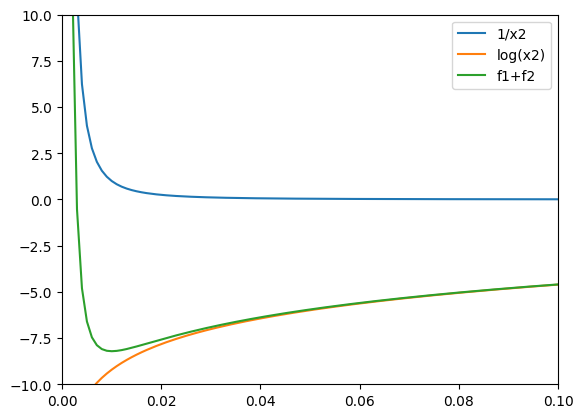

In [ ]:
x  = np.linspace(1e-8, 1, 1000)
f1 = lambda x: 1e-4/x**2
f2 = lambda x: np.log(x**2)

plt.plot(x, f1(x), label="1/x2")
plt.plot(x, f2(x), label="log(x2)")
plt.plot(x, f1(x)+f2(x), label="f1+f2")
plt.legend()
plt.ylim(-10,10)
plt.xlim(-0,1e-1)
